In [2]:
#initiate imports

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime,timezone
import json
import math
from scipy.stats import linregress

In [3]:
#api for nomics https://api.nomics.com/
apk="m_9386cac54693578a1cbfb3729a22c0c080769888"

In [4]:
#add one second to time for next request so that I can aggregate charts
def updatetime ():

    new_hour=0
    new_minute=0
    new_second=0


    if (last_second<59):
        new_second=last_second+1
        new_hour=last_hour
        new_minute=last_minute
    else:#second flips to 00
        new_second=0
        if (last_minute<59):
            new_minute=last_minute+1 
            new_hour=last_hour
        else:#minute flips to 00
            new_minute=0
            if (last_hour<23):
                new_hour=last_hour+1 
            else:
                new_hour=0

    #converts back to string ex: '09' 
    if (new_second<10):
         new_second='0'+str(new_second)
    else:
        str(new_second)

    if (new_minute<10):
         new_minute='0'+str(new_minute)
    else:
        str(new_minute)

    if (new_hour<10):
         new_hour='0'+str(new_hour)
    else:
        str(new_hour)
        
    
    return f'T{new_hour}%3A{new_minute}%3A{new_second}Z'

In [5]:
#exchange history
def new_request():
    url = f'https://api.nomics.com/v1/trades?key={apk}&exchange=binance&market={crypto}USDT&limit={my_limit}&order=asc&from={start_date}{start_time}'
    return requests.get(url).json()

In [10]:
#build data frame for expressed time and crypto
#UCT time is 8 hours ahead, so this would be 02:00:00am PST
request_num=2

crypto='BTC'
start_time='T23%3A30%3A00Z'
start_date='2021-12-10'
end_day=14 #utc day (for now only works if in the same month!!)
end_hour=8 #utc
my_limit=2500
my_df_lenght=my_limit

#the initial request
df=pd.DataFrame(new_request())
print(f'request: {1}')


#loop while conditions are true
my_conditions=True
my_limit=len(df)


while my_conditions:
    last_time=df.iloc[-1:].timestamp
    last_hour=int(last_time.str.split('T')[my_df_lenght-1][1].split(':')[0])
    last_minute=int(last_time.str.split('T')[my_df_lenght-1][1].split(':')[1])
    last_second=int(last_time.str.split('T')[my_df_lenght-1][1].split(':')[2].split('.')[0])
    last_day=int(df.iloc[-1:].timestamp[my_df_lenght-1].split('T')[0].split('-')[2])
    start_time=updatetime()
    
    if (last_day<=end_day):
        my_conditions=True
        if (last_hour<end_hour):
            my_conditions=True
            print('true')
        else:
            my_conditions=False
            print("TFALSEEEEE")         
    else:
        my_conditions=False
        print("FALSEEEEE")
            
    if (my_conditions):
        new_df=pd.DataFrame(new_request())
        df=pd.concat([df, new_df])
        df.reset_index(inplace=True)
        del df['index']
        my_df_lenght=len(df)
        print(f'request: {request_num} and new df lenght is {my_df_lenght}')
        request_num=request_num+1
        
df
  

request: 1
TFALSEEEEE


,id,timestamp,price,volume
0,1028358643,2021-12-10T23:30:00.001Z,47631.98000000,0.00066000
1,1028358644,2021-12-10T23:30:00.002Z,47631.98000000,0.00830000
2,1028358645,2021-12-10T23:30:00.006Z,47631.98000000,0.00036000
3,1028358646,2021-12-10T23:30:00.007Z,47629.36000000,0.00202000
4,1028358647,2021-12-10T23:30:00.021Z,47631.75000000,0.00048000
...,...,...,...,...
2495,1028361138,2021-12-10T23:35:36.944Z,47515.62000000,0.00107000
2496,1028361139,2021-12-10T23:35:36.959Z,47515.62000000,0.01100000
2497,1028361140,2021-12-10T23:35:36.994Z,47515.62000000,0.00304000
2498,1028361141,2021-12-10T23:35:37.035Z,47515.62000000,0.00107000


In [1280]:
#see built df
df.timestamp=pd.to_datetime(df['timestamp'])
df

,id,timestamp,price,volume
0,867916,2021-12-10 19:30:58.604000+00:00,0.47900000,29.00000000
1,867917,2021-12-10 19:31:03.478000+00:00,0.47960000,44.00000000
2,867918,2021-12-10 19:31:06.213000+00:00,0.47970000,25.00000000
3,867919,2021-12-10 19:31:06.234000+00:00,0.47980000,19.00000000
4,867920,2021-12-10 19:31:13.814000+00:00,0.48010000,500.00000000
...,...,...,...,...
3595,871582,2021-12-10 23:01:32.528000+00:00,0.48690000,1708.00000000
3596,871583,2021-12-10 23:01:35.677000+00:00,0.48680000,55.00000000
3597,871584,2021-12-10 23:01:40.836000+00:00,0.48550000,1851.00000000
3598,871585,2021-12-10 23:01:40.836000+00:00,0.48540000,3057.00000000


In [1275]:
#change price to a float
df['price']=df['price'].astype(float)

In [1281]:
df.reset_index(inplace=True)

In [1246]:
#converts UTC time zone to Pacific and then to string for chart
#for index, row in df.iterrows():
#    utc_dt =pd.to_datetime(row.timestamp)
#    pst_tz = timezone('US/Pacific')
#    pst_dt = pst_tz.normalize(utc_dt.astimezone(pst_tz))
#    df.timestamp[index]=pd.to_datetime(pst_dt)

#df.timestamp=df.timestamp.astype(str)
#df

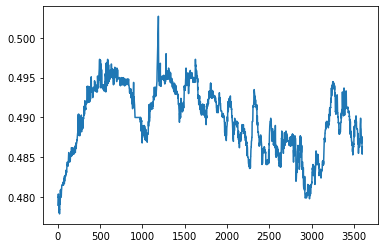

In [1283]:
#plot #I lost on this one as it never got high enough -  I bought in at 14.1 and manually sold at 12.7 ish
df.to_csv('powr_10_test.csv')
plt.plot(df.price.astype(float))
#plt.savefig('dec8_9_MASK_spike.png')

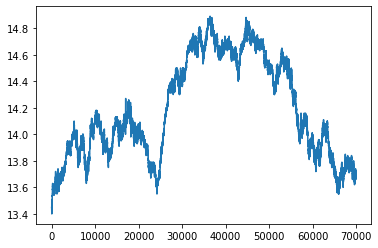

In [1255]:
#plot #I lost on this one as it never got high enough -  I bought in at 14.1 and manually sold at 12.7 ish
#df.to_csv('alice_8_9_test.csv')
plt.plot(df.price.astype(float))
#plt.savefig('dec8_9_MASK_spike.png')

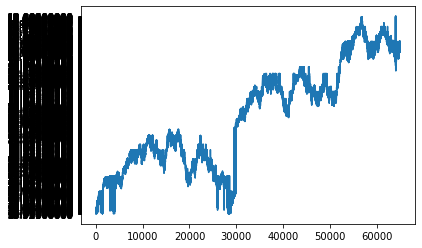

In [1198]:
plt.plot(df.price)

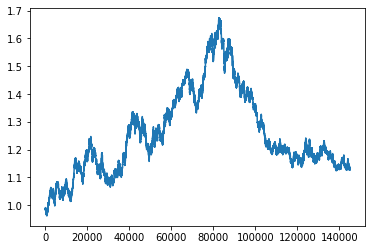

In [658]:
#plot
plt.plot(df.price)
plt.savefig('dec2kmd_spike.png')

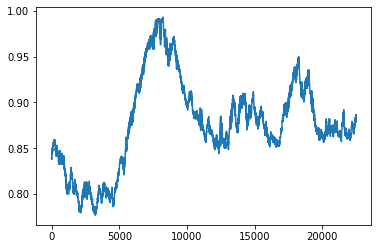

In [650]:
#plot
plt.plot(df.price)
plt.savefig('dec6kmd_spike.png')

In [638]:
#save the csv
#df.to_csv('dec_6_spike_kmd.csv')

In [1192]:
df=pd.read_csv('dec_2_spike_kmd.csv')
#can upload this: 'dec_2_spike_kmd.csv'
#test bot
hold=0#default
buy_price=0 #default
old_price=1.2 #when to buy
sell_price=0 #default
new_high=0 #default
original_spend=5000
spend=original_spend #how much to invest
for i, j in df.iterrows():

    if (j.price>old_price and hold==0):
        buy_price=j.price
        new_high=buy_price
        print(f'num={i}')
        print(j.timestamp)
        hold=1
    if (j.price>new_high):
        new_high=j.price
    if (hold==1 and j.price<=new_high*.96 and j.price>buy_price*1.1):#makes sure there isn't a loss for the sell
        sell_price=j.price
        print(f'num={i}')
        print(j.timestamp)
        hold=2
        
    if (hold==2 and j.price>=new_high*1):
        spend=spend+((sell_price/buy_price)*(spend*.98)-spend)
        buy_price=j.price
        new_high=buy_price
        #I will rebuy here with total .... {(sell_price/buy_price)*(spend*.98)-spend}
        hold=1 
        print(f'num={i}')
        print(j.timestamp)
            
print (buy_price)
print (sell_price)
print (f'You made ${(sell_price/buy_price)*(spend*.98)+spend-original_spend*2}')

#maybe not reinvest all option so if It hits 500 keeps 250 for a guaranteed profit?
#and when it hits check to see if there recent twitter post counts?
#time limit or too low?
#perhaps check to see trend and if it jumps by a percentage even if it isn't a new high? 10%?  track new low after new high and if suddenly it jumps up even if it isn't at new high buy again?
#check predictions? in the api

num=20614
2021-12-02T15:56:40.809Z
num=68625
2021-12-02T17:58:18.47Z
num=76033
2021-12-02T18:01:44.625Z
1.4888
1.4287
You made $1317.4185090772808


In [1191]:

df=pd.read_csv('dec_6_spike_kmd.csv')
#test bot
hold=0#default
buy_price=0 #default
old_price=.86 #when to buy
sell_price=0 #default
new_high=0 #default
original_spend=5000
spend=original_spend #how much to invest
for i, j in df.iterrows():

    if (j.price>old_price and hold==0):
        buy_price=j.price
        new_high=buy_price
        print(f'num={i}')
        print(j.timestamp)
        hold=1
    if (j.price>new_high):
        new_high=j.price
    if (hold==1 and j.price<=new_high*.96 and j.price>buy_price*1.1):#makes sure there isn't a loss for the sell
        sell_price=j.price
        print(f'num={i}')
        print(j.timestamp)
        hold=2
        
    if (hold==2 and j.price>=new_high*1):
        spend=spend+((sell_price/buy_price)*(spend*.98)-spend)
        buy_price=j.price
        new_high=buy_price
        #I will rebuy here with total .... {(sell_price/buy_price)*(spend*.98)-spend}
        hold=1 
        print(f'num={i}')
        print(j.timestamp)
            
print (buy_price)
print (sell_price)
print (f'You made ${(sell_price/buy_price)*(spend*.98)+spend-original_spend*2}')

num=5500
2021-12-06T16:03:52.921Z
num=8457
2021-12-06T16:07:45.348Z
0.8603
0.9531
You made $428.5598047192834


In [ ]:
################## MY MILLIONAIRE BOT #######################

In [718]:
import cbpro

In [737]:
#get available products
pc=cbpro.PublicClient()
results=pc.get_products()
for row in results:
    print(row['id'])

CHZ-USD
PAX-USD
FIL-USD
REN-BTC
PERP-USD
ETH-USDC
NKN-USD
BAT-BTC
CRV-BTC
CTSI-USD
CVC-USDC
FX-USD
STORJ-BTC
ZEC-USD
ZRX-USD
DASH-BTC
AXS-BTC
MASK-USDT
UST-EUR
MASK-USD
LCX-USDT
VGX-USD
MIR-BTC
ADA-EUR
DOGE-USDT
CVC-USD
NU-USD
RAD-USD
BAND-EUR
WLUNA-GBP
ENJ-BTC
LTC-USD
SNX-EUR
NU-GBP
KRL-USDT
NMR-EUR
OMG-EUR
TRAC-USD
NMR-USD
ZRX-EUR
REN-USD
POLY-USD
GTC-USD
YFI-BTC
ALCX-USDT
ETC-BTC
MCO2-USDT
RLY-GBP
LCX-EUR
GRT-USD
UST-USDT
ETH-USDT
CRV-EUR
UMA-EUR
XLM-USD
BCH-BTC
CLV-GBP
ALCX-EUR
SNX-GBP
NMR-BTC
EOS-EUR
XYO-USDT
IOTX-USDT
MANA-ETH
UMA-BTC
TRIBE-USD
DOGE-USD
RAD-GBP
KRL-EUR
OMG-GBP
TRU-USDT
AXS-USD
ETH-BTC
DASH-USD
BTRST-USDT
FIL-EUR
POWR-USDT
RGT-USD
FET-USD
MANA-USDC
LOOM-USDC
ARPA-EUR
FORTH-EUR
STORJ-USD
1INCH-BTC
BAT-EUR
MLN-USD
MIR-GBP
ASM-USD
UNI-USD
BAT-USDC
CRO-EUR
DOGE-GBP
WCFG-GBP
REP-USD
BICO-USD
FOX-USDT
BNT-USD
SOL-GBP
FARM-USDT
MANA-USD
KNC-USD
ZEN-BTC
ETC-USD
AXS-EUR
ENS-USD
ICP-BTC
DDX-USDT
MATIC-USD
IDEX-USD
BTC-USDC
UNI-GBP
ARPA-USD
CGLD-BTC
CHZ-EUR
RAD-EUR
CGLD-GBP


In [833]:
#get my coinbase psscodes
myps=open('../phrase.txt','r').read().splitlines()
public = myps[2].split(':')[1]
passphrase = myps[0].split(':')[1]
secret = myps[1].split(':')[1]

In [1225]:
#create my client
auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)

In [850]:
#verify my client
auth_client.get_accounts()

[{'id': '6816884e-323c-4bbe-a17d-19f983531c08',
  'currency': '1INCH',
  'balance': '0.0000000000000000',
  'hold': '0.0000000000000000',
  'available': '0',
  'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24',
  'trading_enabled': True},
 {'id': 'a6c04dbc-7d9d-47ad-9e00-2496e9c83d55',
  'currency': 'AAVE',
  'balance': '0.0000000000000000',
  'hold': '0.0000000000000000',
  'available': '0',
  'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24',
  'trading_enabled': True},
 {'id': 'fd3a3da9-f798-4d37-9a24-95b0e85765a5',
  'currency': 'ACH',
  'balance': '0.0000000000000000',
  'hold': '0.0000000000000000',
  'available': '0',
  'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24',
  'trading_enabled': True},
 {'id': '12e1a26d-c4b6-4de5-a58e-ca617e550262',
  'currency': 'ADA',
  'balance': '0.0000000000000000',
  'hold': '0.0000000000000000',
  'available': '0',
  'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24',
  'trading_enabled': True},
 {'id': '980f54ed-c254-4359-84d1-769f

In [ ]:
#function to get floor down to two decimal places
def floor_balance(value):
    return math.floor(value*100)/100

In [778]:
#ticker for crypto
def ticker_update(my_ticker):
    import requests

    url = "https://api.exchange.coinbase.com/products/"+my_ticker+"-USD/ticker"

    headers = {"Accept": "application/json"}

    response = requests.request("GET", url, headers=headers)

    return response

In [1039]:
#gets available balance for sell or buy
def get_balance(curr):
    for account in accounts:
        currency=account.get('currency')
        if currency==curr:
            acc_id=account.get('id')
            print(curr)
            print(auth_client.get_account(acc_id))
    return auth_client.get_account(acc_id)['available']

In [1083]:
#function to calculate needed value to sell, etc. for bot
def output_req(buy_price,profit_limit,sell_limit):
    purchase=10
    profit_req=buy_price*profit_limit
    high_req =100/(sell_limit*100)*profit_req
    print(f'sell price if only hits minimum: {profit_req}')
    print(f'will at least need to hit this price to auto sell {high_req}')

In [1240]:
print(float(ticker_update('ASM').json()['price']))
print(float(ticker_update('POWR').json()['price']))
print(float(ticker_update('DDX').json()['price']))
print(float(ticker_update('SKL').json()['price']))
print(float(ticker_update('MATIC').json()['price']))

0.09811
0.4723
4.54
0.2132
2.1709


In [1466]:
def get_products():
    my_products=auth_client.get_products()
    avail_products=[]

    for product in my_products:

        if (product['id'].split('-')[1]=='USDT'):
            if (product['cancel_only']==False and product['limit_only']== False and
                product['trading_disabled']== False and product['auction_mode']==False and
                product['fx_stablecoin']==False): 
                avail_products.append(product['id'].split('-')[0])#'trading_disabled''limit_only': True, 'cancel_only':
    #print (avail_products)
    #print (len(avail_products))
    return (avail_products)

In [1468]:
get_products()#DOGE,CRO,CHZ,SPELL,GALA,KRL,TRU,REQ,RLY,WCFG

['CHZ',
 'SPELL',
 'POLS',
 'ICP',
 'GALA',
 'CRO',
 'SHIB',
 'KRL',
 'SOL',
 'BTRST',
 'TRU',
 'MASK',
 'REQ',
 'PERP',
 'RLY',
 'ASM',
 'BTC',
 'ETH',
 'RAD',
 'WCFG',
 'WLUNA',
 'XYO',
 'AUCTION',
 'FET',
 'DOGE',
 'SUKU',
 'ORN',
 'CLV',
 'ENS',
 'AXS',
 'AVAX',
 'BADGER',
 'DOT',
 'ARPA',
 'AGLD']

In [1503]:
def normalize(values):
    return (values - values.min())/(values.max() - values.min())
    #return (values - values.min())/(values.max() - values.min())

In [1499]:
y=normalize(pd.DataFrame({'temp':[.1677,.1781]}))
slope, intercept, r_value, p_value, std_err = linregress([0,1],y.temp)
slope

0.01040000000000002

In [1498]:
slope

0.0

In [1447]:
ticker_update(product).json()

{'trade_id': 568817,
 'price': '5.45',
 'size': '0.12',
 'time': '2021-12-12T05:43:37.436221Z',
 'bid': '5.43',
 'ask': '5.45',
 'volume': '46034.84'}

In [ ]:
### add an eject button if it hits too low!
#MILLIONAIR BOT

auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)
first_run=True #set this to false if cell is interuppted and I want to continue where left off
is_live=False #won't actually buy or sell


#creates a general array for y to help figure out slope of product
win_index=[]#length of the array for window #time sleep every one second then this is about 3 1/2 minutes - corresponds with time below
for i in range(0,90):
    win_index.append(i)


#the possible products    
the_products=get_products()
product_pool={}

for product in the_products:
    product_pool[product]=[]
    
#so! now I need to have it cycle through all available products and each time one matches
#the requirements, it buys and is moved into an available dictionary INCLUDING THE WINDOW
#after it sells it is moved back into circulation
#including the additional funds and the spend adjusts accordingly
        
#!!!! Temporarily overrides the entire product pool until I can find a faster way to cycle through
#the_products=['DOGE','CRO','CHZ','SPELL','GALA','TRU','REQ','RLY','WCFG']
#product_pool={'DOGE':[],'CRO':[],'CHZ':[],'SPELL':[],'GALA':[],'TRU':[],'REQ':[],'RLY':[],'WCFG':[]}    

#initializes the bots - might just be able to do one at a time unless find a way to further limit but for now 1
if (first_run==True):
    dict1 = {'crypto': '', 'hold':0,'buy_price':0 ,'new_high':0,'spend':0,'window':[]}
    #dict2 = {'crypto': '', 'hold':0,'buy_price':0 ,'new_high':0,'spend':0}
    #dict3 = {'crypto': '', 'hold':0,'buy_price':0 , 'new_high':0,'spend':0}
    #dict4 = {'crypto': '', 'hold':0,'buy_price':0 , 'new_high':0,'spend':0}
    
    currencies=[dict1] #start with just 1
    
    available_slots=len(currencies) #match the number of dictionaries possible
    
    hold=0 #0=initial, 1=hold, 2=sold (back to 0 to be put back in circulation)
    
    profit_limit=1 #sets the desired profit before selling
    sell_limit=.98 #will sell if the high price drops to this percentage (if profit limit is met too)
    #high_increase=1.0 #will buy again if price hits the current high multiplied by this
    
    #sets the spend value for each dictionary

    
print ('Bot Started!')
bot_count=0
hit_window=False
    
while True:#currently this keeps running until manually exiting
    
    
    
    
    auth_client = cbpro.AuthenticatedClient(public,secret,passphrase)
    
    #for product in the_products:
        
    price=float(ticker_update('GALA').json()['price'])
      #  product_pool[product].append(price)
        
        #bot_count=bot_count+1
        #if (bot_count==12):
         #   print(f'{product} price update at:{price} - to make sure is still live')
          #  print(len(product_pool[product]))
           # bot_count=0

        #if (len(product_pool[product])>=90):
            #print('yes')
         #   if (hit_window==False):
          #      hit_window=True
           #     print ('Let us get those buys!')
            #x = win_index
            #y = pd.DataFrame({'temp':product_pool[product]}).temp
            
            
            #!!!!!!!! THIS IS MAKING IT GO SLOW!
            #slope, intercept, r_value, p_value, std_err = linregress(x, normalize(y))
            #print(slope)
            #product_pool[product].pop(0)

    in_circulation=True

    #if not in circulation sees if a slot is available for another purchase
    #empty_slot=0 #if 0 there is no available slots for a new purchase
    #slot_count=0
    #the_slot=-1

    #for currency in currencies:

     #   if (currency['crypto']==product): #LINE 74
      #      in_circulation=True
       # if (currency['crypto']==''):
        #    the_slot=slot_count
        #slot_count=slot_count+1


    if (in_circulation==True):
        type_crypto='GALA'
        type_exchange=type_crypto+'-USDT'
        buy_price=currencies[the_slot]['buy_price']
        new_high=currencies[the_slot]['new_high']
        spend=currencies[the_slot]['spend']
        hold=currencies[the_slot]['hold']

    #check to see if it is already bought and in current circulation
    if (hold==0): ##just works with under 1 dollar for now
        #if (the_slot!=-1):
         #   currencies[the_slot]['crypto']=product #adds to the slot


        if (is_live==True):
            original_spend=float(get_balance('USDT')) #amount to spend initially on first buy
        else:
            original_spend=1000

        #currencies[the_slot]['spend']=original_spend/available_slots

        #in_circulation=True
        #available_slots=available_slots-1

        buy_price=price
        new_high=buy_price
        print('')
        print('PURCHASE ORDER:')
        print(f'date: {datetime.now()}')
        print (f'{type_crypto} :${price}')
        #print(f'buy slope: {slope}')
        #print(f'buy r squared: {r_value*r_value}')
        print('')
        print(output_req(buy_price,profit_limit,sell_limit))
        print('')

        if (is_live==True):
            the_bought=(auth_client.place_market_order(type_exchange, 'buy', funds=floor_balance(spend)))

            #checks to see if buy goes through
            if (len(the_bought)==1):
                print (the_bought)
                currencies[the_slot]['spend']=0
                currencies[the_slot]['crypto']=''
                hold=0
                print ('the buy did not go through')
            else:
                output_req(buy_price,profit_limit,sell_limit)
                currencies[the_slot]['hold']=1



    active=True
    while (active==True):
        
        price=float(ticker_update('ASM').json()['price'])

        if (price>new_high):
            new_high=price
            print(new_high)

        if (hold==1 and ((price<=new_high*sell_limit and price>buy_price*profit_limit))):#makes sure there isn't a loss for the sell
            print('')
            print('SELL ORDER:')
            print(f'date: {datetime.now()}')
            print(f'sell price: {price}')
            print(f'sell slope: {slope}')
            print(f'sell r squared: {r_value*r_value}')
            print('')

            if (is_live==True):
                print(auth_client.place_market_order(type_exchange, 'sell', size=floor_balance(float(get_balance(type_crypto)))))
            active=False


    #reset values
    currencies[the_slot]['crypto']=''
    currencies[the_slot]['hold']=0
    currencies[the_slot]['hold']=0
    currencies[the_slot]['new_high']=0
    currencies[the_slot]['spend']=0
    available_slots=available_slots+1

    #back_up values before moving to next currency when several are active but that is not the case now
    #if (currencies[the_slot]!=''):
    #   currencies[the_slot]['buy_price']=buy_price
    #currencies[the_slot]['new_high']=new_high
    #currencies[the_slot]['spend']=spend
    #currencies[the_slot]['hold']=hold


Bot Started!

PURCHASE ORDER:
date: 2021-12-12 08:03:27.789083
GALA :$0.57559

sell price if only hits minimum: 0.57559
will at least need to hit this price to auto sell 0.5873367346938776
None



In [1507]:
len(product_pool[product])

89

In [1189]:
#manually sell my current one
#print(auth_client.place_market_order('MASK-USDT', 'sell', size=floor_balance(float(get_balance('MASK')))))

MASK
{'id': 'f8765463-bde3-4c7c-8c92-4484ba10d156', 'currency': 'MASK', 'balance': '0.9200000000000000', 'hold': '0.0000000000000000', 'available': '0.92', 'profile_id': 'e4ceef7d-bf47-4805-9db1-a65dacc3eb24', 'trading_enabled': True}
{'id': '52125c98-1635-47c0-b4d3-072c04e125fa', 'size': '0.92', 'product_id': 'MASK-USDT', 'side': 'sell', 'stp': 'dc', 'type': 'market', 'post_only': False, 'created_at': '2021-12-10T03:05:23.87493Z', 'fill_fees': '0', 'filled_size': '0', 'executed_value': '0', 'status': 'pending', 'settled': False}


In [857]:
#manually buy
#auth_client.place_market_order('BTC-USDT', 'buy', funds=5)

{'id': '2b89d592-6411-45d2-a397-6bc07c39985b',
 'product_id': 'BTC-USDT',
 'side': 'buy',
 'stp': 'dc',
 'funds': '4.97512437',
 'specified_funds': '5',
 'type': 'market',
 'post_only': False,
 'created_at': '2021-12-08T21:50:28.975657Z',
 'fill_fees': '0',
 'filled_size': '0',
 'executed_value': '0',
 'status': 'pending',
 'settled': False}

In [1350]:
#manually sell 
#a=auth_client.place_market_order('DDX-USDT', 'sell', funds=1)


In [11]:
import requests

url = "https://api.exchange.coinbase.com/products/BTC/candles"

headers = {"Accept": "application/json"}

response = requests.request("GET", url, headers=headers)

print(response.text)

{"message":"NotFound"}
